In [209]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf
import os
import music21 as m21
from music21 import *
import pickle
from tensorflow.keras import layers
from IPython import display
from IPython.display import Image, Audio
from matplotlib import pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
seed = 1339
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 44100

In [200]:
data_dir = pathlib.Path("./data/beeth/")
filenames = glob.glob(str(data_dir/'*.mid*'))
print('Number of files:', len(filenames))

Number of files: 29


In [88]:
def play_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [223]:
pm = pretty_midi.PrettyMIDI(filenames[19])
play_audio(pm)

fluidsynth: warning: SDL2 not initialized, SDL2 audio driver won't be usable
fluidsynth: error: Unknown integer parameter 'synth.sample-rate'
fluidsynth: warning: SDL2 not initialized, SDL2 audio driver won't be usable
fluidsynth: error: Unknown integer parameter 'synth.sample-rate'


In [225]:
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print(instrument_name)

Acoustic Grand Piano


In [226]:
instrument.notes[:10]

[Note(start=0.867049, end=1.087342, pitch=76, velocity=36),
 Note(start=1.087342, end=1.302950, pitch=75, velocity=33),
 Note(start=1.302950, end=1.516823, pitch=76, velocity=39),
 Note(start=1.516823, end=1.727908, pitch=75, velocity=36),
 Note(start=1.727908, end=1.940702, pitch=76, velocity=45),
 Note(start=1.940702, end=2.156003, pitch=71, velocity=40),
 Note(start=2.156003, end=2.371303, pitch=74, velocity=47),
 Note(start=2.371303, end=2.610347, pitch=72, velocity=39),
 Note(start=2.610347, end=3.043999, pitch=69, velocity=51),
 Note(start=3.260824, end=3.470146, pitch=60, velocity=34)]

In [227]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [228]:
raw_notes = midi_to_notes(filenames[19])
raw_notes.head()

pitch     start       end      step  duration
0     76  0.867049  1.087342  0.000000  0.220294
1     75  1.087342  1.302950  0.220294  0.215607
2     76  1.302950  1.516823  0.215607  0.213874
3     75  1.516823  1.727908  0.213874  0.211084
4     76  1.727908  1.940702  0.211084  0.212794

In [229]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str, 
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [230]:
example_file = 'example.midi'
example_pm = notes_to_midi(
    raw_notes, out_file=example_file, instrument_name=instrument_name)
play_audio(example_pm)

fluidsynth: warning: SDL2 not initialized, SDL2 audio driver won't be usable
fluidsynth: error: Unknown integer parameter 'synth.sample-rate'


In [231]:
num_files = 29
all_notes = []
for f in filenames[:num_files]:
  notes = midi_to_notes(f)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)
all_notes

pitch       start         end      step  duration
0       60    1.628172    2.146812  0.000000  0.518640
1       56    2.146812    2.283411  0.518640  0.136599
2       53    2.283411    3.952758  0.136599  1.669347
3       56    3.952758    4.430089  1.669347  0.477331
4       60    4.430089    4.537516  0.477331  0.107427
..     ...         ...         ...       ...       ...
704     74  555.748211  555.812361  0.064959  0.064150
705     76  555.812361  555.876247  0.064150  0.063886
706     74  555.876247  555.941705  0.063886  0.065458
707     76  555.941705  556.006996  0.065458  0.065291
708     74  556.006996  556.071847  0.065291  0.064851

[53392 rows x 5 columns]

In [232]:
train_notes = all_notes[['pitch', 'step','duration']]
train_notes

pitch      step  duration
0       60  0.000000  0.518640
1       56  0.518640  0.136599
2       53  0.136599  1.669347
3       56  1.669347  0.477331
4       60  0.477331  0.107427
..     ...       ...       ...
704     74  0.064959  0.064150
705     76  0.064150  0.063886
706     74  0.063886  0.065458
707     76  0.065458  0.065291
708     74  0.065291  0.064851

[53392 rows x 3 columns]

create training data and labels
    

In [150]:
sample_length = 50 #should be tuned
vocab_size = 128

creating a dataset by taking sample_lenght number of notes as Xtrain and the next note as target 

In [151]:
# for i in range(0,len(train_notes)-sample_length-1):
#     subsample = train_notes[i:i+sample_length+1].to_numpy().flatten()
#     subsample = np.reshape(subsample,(sample_length+1,3))
#     if i== 0:
#         Xtrain = subsample[np.newaxis,0:-1]/[vocab_size,1.0,1.0]
#         ytrain = subsample[np.newaxis,-1]
#     else:
#         Xtrain = np.vstack((Xtrain,subsample[np.newaxis,0:-1]/[vocab_size,1.0,1.0]))
#         ytrain = np.vstack((ytrain,subsample[np.newaxis,-1]))
# print(Xtrain.shape)
# print(ytrain.shape)

(53341, 50, 3)
(53341, 3)


In [152]:
# with open('Xtrain.pickle', 'wb') as f:
#     pickle.dump(Xtrain, f)
# with open('ytrain.pickle', 'wb') as f:
#     pickle.dump(ytrain, f)

In [25]:
with open('Xtrain.pickle','rb') as f:
    Xtrain = pickle.load(f)
with open('ytrain.pickle','rb') as f:
    ytrain = pickle.load(f)

In [170]:


input_shape = (sample_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(inputs)
x = layers.Dropout(.2)(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
outputs = (tf.keras.layers.Dense(128, name='pitch')(x),tf.keras.layers.Dense(1, name='step')(x),tf.keras.layers.Dense(1, name='duration')(x))


model = tf.keras.Model(inputs, outputs)

loss = (tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),tf.keras.losses.MeanSquaredError(), tf.keras.losses.MeanSquaredError(),)

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss,    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    }, optimizer=optimizer)

model.summary()



Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 50, 3)]      0           []                               
                                                                                                  
 bidirectional_40 (Bidirectiona  (None, 50, 128)     34816       ['input_21[0][0]']               
 l)                                                                                               
                                                                                                  
 dropout_3 (Dropout)            (None, 50, 128)      0           ['bidirectional_40[0][0]']       
                                                                                                  
 bidirectional_41 (Bidirectiona  (None, 128)         98816       ['dropout_3[0][0]']       

In [171]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [185]:
%%time
epochs = 50

history = model.fit(
    x=Xtrain,
    y=[ytrain[:,0],ytrain[:,1],ytrain[:,2]],
    epochs=epochs,
    callbacks=callbacks,
    shuffle=True,
    batch_size=128
)




Epoch 1/50
417/417 [==============================] - 75s 179ms/step - loss: 1.6895 - pitch_loss: 3.5631 - step_loss: 1.4399 - duration_loss: 0.0715
Epoch 2/50
417/417 [==============================] - 81s 194ms/step - loss: 1.6739 - pitch_loss: 3.3475 - step_loss: 1.4384 - duration_loss: 0.0682
Epoch 3/50
417/417 [==============================] - 70s 169ms/step - loss: 1.6617 - pitch_loss: 3.2339 - step_loss: 1.4338 - duration_loss: 0.0662
Epoch 4/50
417/417 [==============================] - 88s 212ms/step - loss: 1.6516 - pitch_loss: 3.1244 - step_loss: 1.4305 - duration_loss: 0.0648
Epoch 5/50
417/417 [==============================] - 87s 208ms/step - loss: 1.6441 - pitch_loss: 3.1428 - step_loss: 1.4246 - duration_loss: 0.0624
Epoch 6/50
417/417 [==============================] - 75s 180ms/step - loss: 1.6446 - pitch_loss: 3.0898 - step_loss: 1.4275 - duration_loss: 0.0627
Epoch 7/50
417/417 [==============================] - 69s 165ms/step - loss: 1.6405 - pitch_loss: 3.1434 -

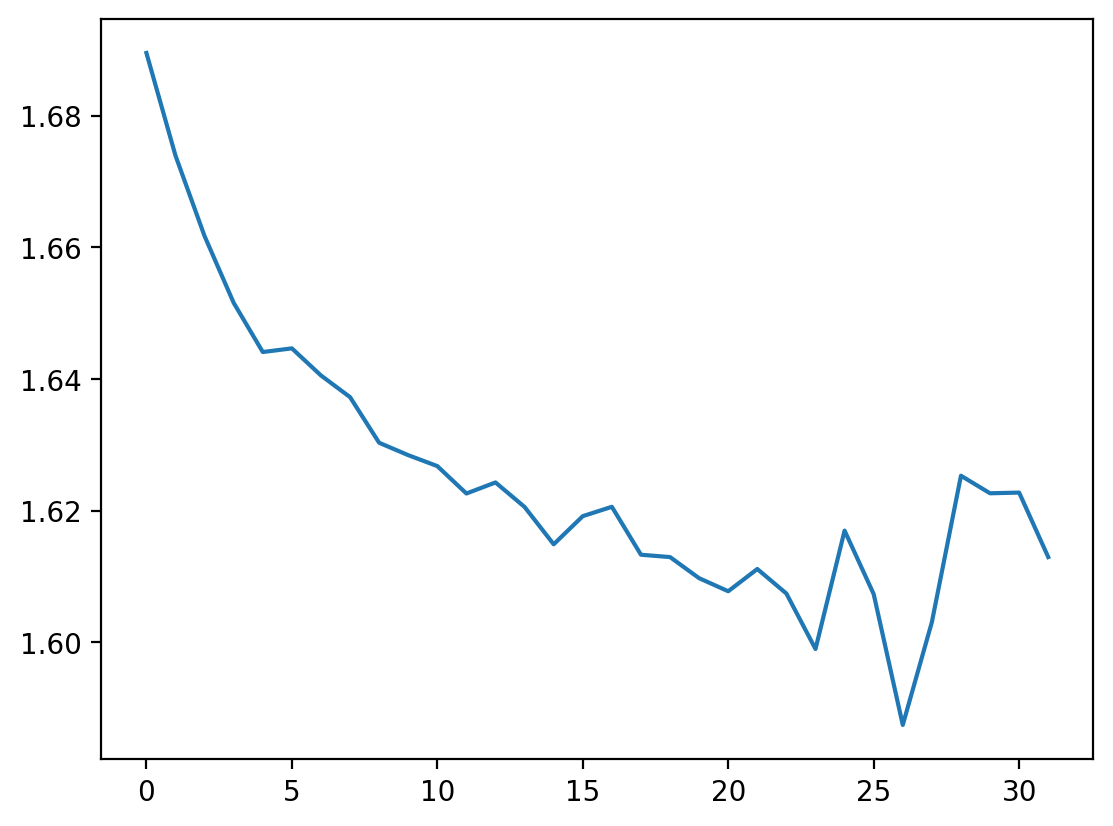

In [186]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

In [235]:
!mkdir -p saved_model
model.save('saved_model/2xbidirectionalLSTM')


INFO:tensorflow:Assets written to: saved_model/2xbidirectionalLSTM/assets


INFO:tensorflow:Assets written to: saved_model/2xbidirectionalLSTM/assets


In [187]:
def predict_next_note(
    notes: np.ndarray, 
    keras_model: tf.keras.Model, 
    temperature: float = 1.0) -> int:
  """Generates a note IDs using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
 # print(predictions)
  pitch_logits = predictions[0]
  step = predictions[1]
  duration = predictions[2]
 
  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

In [233]:
temperature = 3.0
num_predictions = 120

key_order = ['pitch', 'step', 'duration']
sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:sample_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions): #replace with predict for n seconds
    [pitch, step, duration] = predict_next_note(input_notes, model, temperature)
    start = prev_start + step
    end = start + duration
    input_note = (pitch, step, duration)
    generated_notes.append((*input_note, start, end))
    input_notes = np.delete(input_notes, 0, axis=0)
    input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
    prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

1/1 [==============================] - 0s 41ms/step


In [234]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
play_audio(out_pm,int(generated_notes.iloc[-1,-1]))

fluidsynth: warning: SDL2 not initialized, SDL2 audio driver won't be usable
fluidsynth: error: Unknown integer parameter 'synth.sample-rate'
